In [1]:
#  This notebook is run to better study a particular model
# We used this to understand our optimal model, and experiment with small alterations

# We now use the full train set on this model, and create learning curves

In [2]:
# Import modules
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import os
import argparse
import tensorflow as tf
from sklearn.model_selection import KFold
import itertools
import pandas as pd
import pickle
from sklearn.metrics import classification_report
from model import TwoLayerNet, ThreeLayerNet, FourLayerNet
from util import *

In [3]:
# Define global variables
global epochs, patience_no, batch_size, optimization_perc

################ Define hyperparameters for this model ####################
epochs = 100
patience_no = 20
batch_size = 1000 # batch size of 1000 seems to be optimal
num_layers = 2 # 2 layers seems to be optimal
dropout_rate = 0.0 # 0 percent dropout percentage seems to be optimal
beta_1_param = 0.990 # It appears beta_1_param=0.990 is optimal
num_neurons = 100 # 100 neurons seems to be optimal
use_earlyStopping = True # Using early stoppingm seems to be optimal
reg_scale = 0.0013 # Scale for L2 regularization

# Setting prop to 1 skips over anything to do with the test set
prop=0.9 # Percentage of data to place in training set, (1-prop) goes in test
optimization_perc = 0.9 # Percent of training data to go into optimization (rest goes into validation set)
###########################################################################

In [4]:
# get data and process it
labels = np.load('/work/cse496dl/shared/homework/01/fmnist_train_labels.npy')
data = np.load('/work/cse496dl/shared/homework/01/fmnist_train_data.npy')

# Randomize order
np.random.seed(42) # Seeded so we always get same splits
idx = np.random.permutation(data.shape[0])
data,labels = data[idx], labels[idx]

# Names of classes
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Directory where models are saved
save_directory = './homework1_sessions'

([<matplotlib.axis.XTick at 0x2aae2759b2e8>,
 <a list of 10 Text xticklabel objects>)

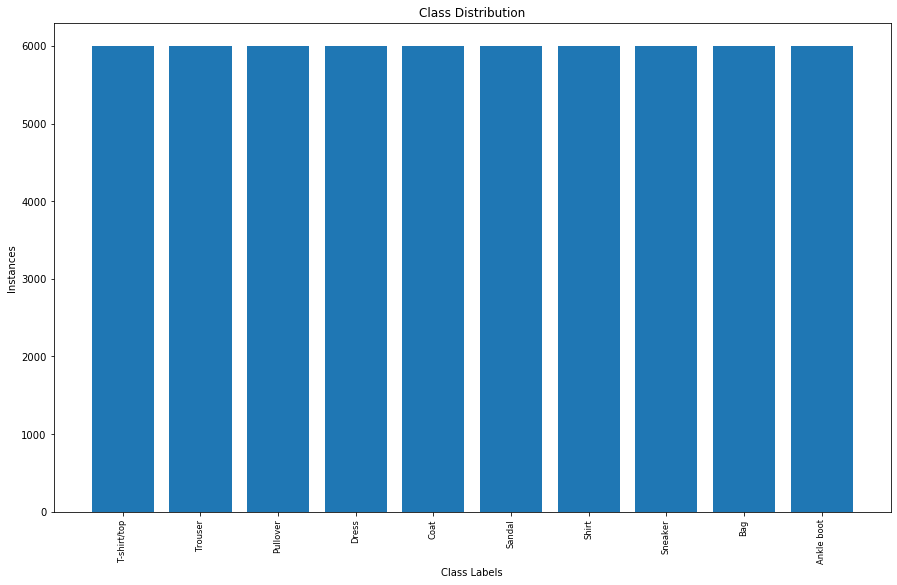

In [5]:
# Create histogram to visualize data

# Shift bins so they line up with labels
bins = np.arange(11) - 0.5

plt.figure(figsize=(15, 9))
plt.hist(labels, rwidth=0.8, align='mid', bins=bins)
plt.title('Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Instances')
# Put actual labels on histogram
plt.xticks(list(range(0,10)) , class_labels , rotation='vertical', fontsize='small')


In [6]:
# Save before one-hot-encoding
raw_labels = [int(label) for label in labels]
#one hot encode labels
labels=one_hot_encode(labels)

# Split data into train and test
train_data,train_labels,test_data,test_labels=split_data(prop,data,labels)
# Grab corresponding raw_labels for train and test
_,train_labels_raw,_,raw_labels=split_data(prop,data,raw_labels)

# Main function for running data through graph
def main_FMNIST(num_layer,epochs,num_neurons,optimizer,patience_number,batch_size,dropout_perc,use_earlyStopping=False):
    
    # Generate default parameters for the Adam Optimizer
    lr,b_1,b_2=generate_adam_param(default=True)
    
    # initialize empty lists
    acc_val_list = []
    ce_val_list = []
    result_list = []
    duplicate_indices = []
    
    # Initialize variable
    fold_count = 1
    
    train_set,train_label,val_set,val_label=split_data(optimization_perc,train_data,train_labels)
    # Grab corresponding raw train labels
    _,train_label_raw,_,_=split_data(optimization_perc,train_data,train_labels_raw)
    
    # Choose which classes to make noisy duplicates for
    duplicate_classes = list(range(0,10)) # Make noisy duplicates of all data in optimization set
    
    # Find and store indices corresponding to classes we want to duplicate
    for index,label in enumerate(train_label_raw):
        if label in duplicate_classes:
            duplicate_indices.append(index)
    
    # Using those make noisy duplicates
    train_set_noisy, train_label_noisy = transform_image(train_set[duplicate_indices], train_label[duplicate_indices])
    
    # Now concatenate these noisy images with the optimization set
    train_set=np.append(train_set, train_set_noisy,axis=0)
    train_label=np.append(train_label, train_label_noisy,axis=0)
    
    # Now randomize the order of the training set to remove any bias we just added
    idx = np.random.permutation(train_set.shape[0]) # Note this is already seeded, so repeatable
    train_set,train_label = train_set[idx], train_label[idx]

    # Count number of optimization, validation, and test images
    num_train_data=train_set.shape[0]
    num_val_data=val_set.shape[0]
    num_test_data = len(test_labels)
    print('We have '+str(num_train_data)+' training images, '+str(num_val_data)+' validation images, and '+str(num_test_data)+' test images')
    
    ############ Run neural network model and grab relevant information ############
    tf.reset_default_graph()
    with tf.Session() as session:
        
        # create tensorflow placeholders for data and labels
        input_tf = tf.placeholder(tf.float32, [None, 784], name='input_placeholder')
        output_tf = tf.placeholder(tf.float32, [None, 10], name='label_placeholder')
        
        # Assign two layer architecture
        if num_layer==2: 
            layer_size_1 = num_neurons*3 # Three times as many neurons in hidden layer 1 as hidden layer 2
            layer_size_2 = num_neurons*1
            confusion_matrix_op_1, cross_entropy_1, train_op_1, global_step_tensor_1, saver_1,accuracy_1, output,merge_1 = TwoLayerNet(input_tf, output_tf, lr, b_1, b_2, layer_size_1, layer_size_2,0.0,optimizer,dropout_perc)
        # Assign 4-layer architecture
        else: 
            layer_size_1 = num_neurons*3 # Three times as many neurons in hidden layer 1 as hidden layer 4
            layer_size_2 = int(num_neurons*2.5)
            layer_size_3 = int(num_neurons*1.5)
            layer_size_4 = num_neurons*1
            confusion_matrix_op_1, cross_entropy_1, train_op_1, global_step_tensor_1, saver_1, accuracy_1, output,merge_1 = FourLayerNet(input_tf, output_tf, lr, b_1, b_2, layer_size_1, layer_size_2,layer_size_3,layer_size_4,0.0,optimizer,dropout_perc)
        
        # Initialize variables in the graph
        session.run(tf.global_variables_initializer())
        
        # Define empty lists
        test_loss=[]
        acc_train_list = []
        ce_train_list = []
        
        # Initialize variables
        count=0
        best_validation_ce=float('inf')
        best_epoch=0
        
        # Go through each epoch
        for i in range(epochs):
            
            # Print which epoch we are in
            print('Running epoch '+str(i) + ' out of ' + str(epochs-1))
            
            ############## Learn From Training Set #################
            
            # Initialize empty lists
            ce_train=[]
            conf_mxs=[]
            acc_train=[]
            
            # Go through each Mini-Batch
            for j in range(num_train_data//batch_size):
                # Grab chosen data and labels
                batch_xs=train_set[j*batch_size:(j+1)*batch_size,:]
                batch_ys=train_label[j*batch_size:(j+1)*batch_size,:]
                
                # Run data through graph
                summary, _, train_ce, conf_matrix, accuracy = session.run([merge_1, train_op_1, cross_entropy_1, confusion_matrix_op_1, accuracy_1], {input_tf: batch_xs, output_tf: batch_ys})
                
                # Append results to lists
                ce_train.append(train_ce)
                conf_mxs.append(conf_matrix)
                acc_train.append(accuracy)
                
            # After all Mini-Batches complete calculate the average values
            avg_train_acc = sum(acc_train) / len(acc_train)
            avg_train_ce = sum(ce_train) / len(ce_train)
            
            # Append these average values to the lists
            acc_train_list.append(avg_train_acc)
            ce_train_list.append(avg_train_ce)
            
            ############## Evaluate On Validation Set #################
            
            # Initialize empty lists
            ce_val=[]
            conf_val=[]
            acc_val=[]
            
            # Go through each Mini-Batch
            for j in range(num_val_data//batch_size):
                # Grab chosen data and labels
                batch_xs=val_set[j*batch_size:(j+1)*batch_size,:]
                batch_ys=val_label[j*batch_size:(j+1)*batch_size,:]
                
                # Run data through graph
                summary, val_ce, conf_matrix, accuracy = session.run([merge_1,cross_entropy_1, confusion_matrix_op_1, accuracy_1], {input_tf: batch_xs, output_tf: batch_ys})
                
                # Append results to lists
                ce_val.append(val_ce)
                conf_val.append(conf_matrix)
                acc_val.append(accuracy)
                
            # After all Mini-Batches complete calculate the average values
            avg_validation_acc = sum(acc_val) / len(acc_val)#val accuracy over the batches
            avg_validation_ce = sum(ce_val) / len(ce_val)
            
            # Append these average values to the lists
            acc_val_list.append(avg_validation_acc)
            ce_val_list.append(avg_validation_ce)
            
            ############## Check Early Stopping Condition #################
            if use_earlyStopping: # This block is only run if we have chosen to implement early stopping
                # If our new validation cross-entropy is smaller than previous run this
                if(best_validation_ce > avg_validation_ce):
                    # Save the epoch number
                    best_epoch=i
                    # Reset the count to 0, if it reaches set number we exit
                    count=0
                    # Redefine the best validation ce as the new one
                    best_validation_ce=avg_validation_ce
                    # Save the session so we can reload it later
                    path_prefix=saver_1.save(session,os.path.join(save_directory,"homework_1"))
                
                 # This block is run if this epoch does not have a smaller validation ce than we have seen
                else:
                    # Increment the count by 1, if it reaches set number we exit
                    count+=1
            
                # This block is run if we have not seen an improvement in the set number of epochs
                if count>= patience_no:
                    print("No improvement found during last iterations, stopping optimization.")
                    # Reload the session which was shown to be optimal
                    # loading the meta graph re-creates the graph structure in the current session
                    saver = tf.train.import_meta_graph(path_prefix + '.meta')
                    # This restores and initializes the saved variables
                    saver_1.restore(session, path_prefix) # restore session with the best ce

                    # Break out of loop
                    break
                    
        # Run only if we have not implemented Early Stopping
        if use_earlyStopping==False:
            # Save the session, as it has not been saved previously
            path_prefix=saver_1.save(session,os.path.join(save_directory,"homework_1"))

        ############## Evaluate On Validation Set #################
        
        # Initialize empty lists
        ce_test=[]
        conf_test=[]
        acc_test=[]
        pred_labels_list = []
        conf_matrix_test = []
        classification_report_test = []
        
        if not num_test_data==0: # Skip if we are not using a test set
            
            # Go through each Mini-Batch
            for j in range(num_test_data//batch_size):
                # Grab subset of data and labels
                batch_xs=test_data[j*batch_size:(j+1)*batch_size,:]
                batch_ys=test_labels[j*batch_size:(j+1)*batch_size,:]
                
                # Run data through model
                summary, test_ce, conf_matrix, accuracy,pred_labels = session.run([merge_1,cross_entropy_1, confusion_matrix_op_1, accuracy_1,tf.argmax(output,1)], {input_tf: batch_xs, output_tf: batch_ys})
                
                # Append results to lists
                ce_test.append(test_ce)
                conf_test.append(conf_matrix)
                acc_test.append(accuracy)
                pred_labels_list.extend(pred_labels)
            
            # After all Mini-Batches complete calculate average values
            acc_test = sum(acc_test) / len(acc_test)
            ce_test = sum(ce_test) / len(ce_test)
            
            # Output values for accuracy and cros-entropy to user
            print('TEST TOTAL ACCURACY: ' + str(acc_test))
            print('TEST TOTAL LOSS: ' + str(ce_test))
            print('')
            
            # Output total test confusion matrix to user
            conf_matrix_test = sum(conf_test)
            print('TEST CONFUSION MATRIX:')
            print(str(conf_matrix_test))
            print('')
            
            # Calculate the classification report (including Recall, Precision, and F1-Score)
            classification_report_test = (classification_report(raw_labels,pred_labels_list,target_names=class_labels))
            # Output classification report to user
            print('')
            print('TEST CLASSIFICATION REPORT:')
            print(str(classification_report_test))
        
    ##### Show overall average accuracy #####
    print('The best epoch found is epoch ' + str(best_epoch))
    print('')
    
    return acc_val_list, ce_val_list, acc_test, ce_test, acc_train_list, ce_train_list, conf_matrix_test,classification_report_test,raw_labels,pred_labels_list,best_epoch


We have 97200 training images, 5400 validation images, and 6000 test images


W0927 22:35:22.869652 46925966712960 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0927 22:35:22.877415 46925966712960 deprecation.py:323] From /lustre/work/centurion/bmoore49/model.py:82: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0927 22:35:23.821405 46925966712960 deprecation.py:323] From /lustre/work/centurion/bmoore49/model.py:85: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.
W0927 22:35:24.121671 46925966712960 deprecatio

Running epoch 0 out of 99
Running epoch 1 out of 99
Running epoch 2 out of 99
Running epoch 3 out of 99
Running epoch 4 out of 99
Running epoch 5 out of 99
Running epoch 6 out of 99
Running epoch 7 out of 99
Running epoch 8 out of 99
Running epoch 9 out of 99
Running epoch 10 out of 99
Running epoch 11 out of 99
Running epoch 12 out of 99
Running epoch 13 out of 99
Running epoch 14 out of 99
Running epoch 15 out of 99
Running epoch 16 out of 99
Running epoch 17 out of 99
Running epoch 18 out of 99
Running epoch 19 out of 99
Running epoch 20 out of 99
Running epoch 21 out of 99
Running epoch 22 out of 99
Running epoch 23 out of 99
Running epoch 24 out of 99
Running epoch 25 out of 99
Running epoch 26 out of 99
Running epoch 27 out of 99
Running epoch 28 out of 99
Running epoch 29 out of 99
Running epoch 30 out of 99
No improvement found during last iterations, stopping optimization.


W0927 22:41:02.439898 46925966712960 deprecation.py:323] From /util/opt/anaconda/deployed-conda-envs/packages/tensorflow/envs/tensorflow-1.14.0-py36/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


TEST TOTAL ACCURACY: 0.8924999932448069
TEST TOTAL LOSS: 0.30175542334715527

TEST CONFUSION MATRIX:
[[568   2   6  17   1   1  24   0   4   0]
 [  2 575   0   8   2   0   0   0   1   0]
 [ 15   0 463   7  76   0  23   0   4   0]
 [ 17   3   7 554  14   0   7   0   3   0]
 [  1   4  40  28 521   0  10   0   3   0]
 [  0   0   0   1   0 533   0  15   1   7]
 [110   2  54  12  48   0 360   0   6   0]
 [  0   0   0   0   0   5   0 628   0  10]
 [  3   0   4   1   4   0   0   1 570   1]
 [  0   0   0   0   0   4   0  26   0 583]]


TEST CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.91      0.85       623
     Trouser       0.98      0.98      0.98       588
    Pullover       0.81      0.79      0.80       588
       Dress       0.88      0.92      0.90       605
        Coat       0.78      0.86      0.82       607
      Sandal       0.98      0.96      0.97       557
       Shirt       0.85      0.61      0.71       592
     

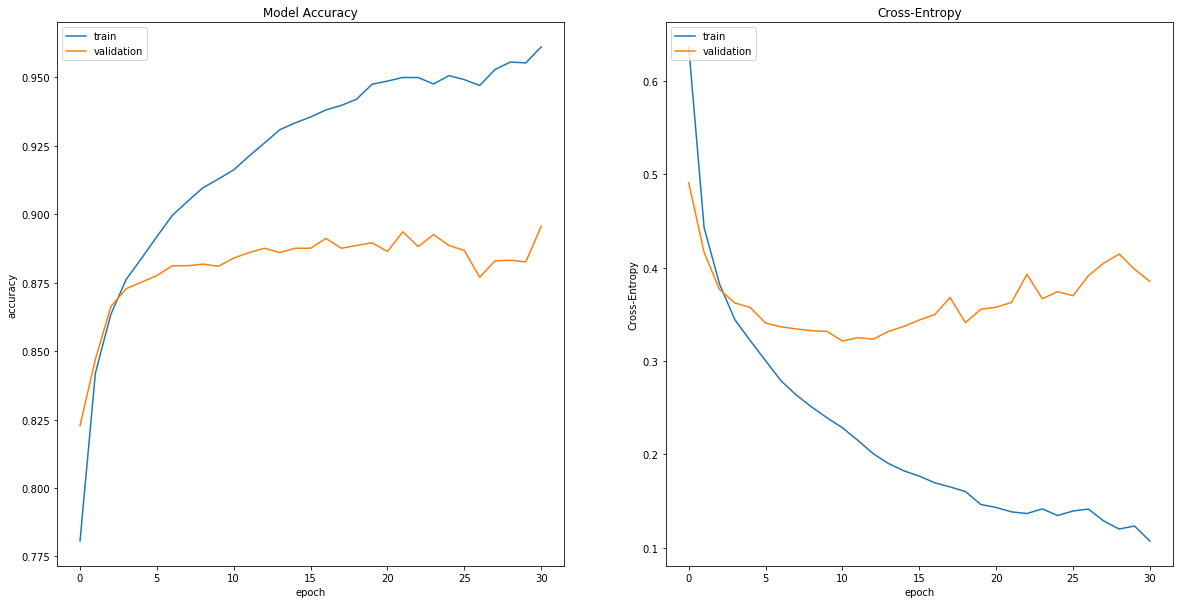

In [7]:
############ This defines grid-search and runs all iterations through model ############

# Define pandas dataframe to hold results
df_grid_search = pd.DataFrame(columns=['Beta_1_Param','Num_Neurons','use_earlyStopping','Dropout_Perc','Num_Layers','Acc_Fold_1','Acc_Fold_2','Acc_Fold_3','Acc_Fold_4','Acc_Fold_5','CE_Fold_1','CE_Fold_2','CE_Fold_3','CE_Fold_4','CE_Fold_5'])

# Define the Adam Optimizer
optimizer = tf.train.AdamOptimizer(beta1=beta_1_param)

# Run Data through graph with chosen Hyperparameters and collect the results
acc_val_list,ce_val_list,acc_test,ce_test, acc_train_list, ce_train_list, conf_matrix_test, classification_report_test,actual_labels_test,pred_labels_test,best_epoch=main_FMNIST(num_layers,epochs,num_neurons,optimizer,patience_no,batch_size,dropout_rate,use_earlyStopping)

# Create and plot the learning curve using training and validation sets
plot_learning_curve(acc_train_list,acc_val_list,ce_train_list,ce_val_list)

# Save the correct test class labels as pickle file for later analysis
pickle_out = open("actual_labels_test.pickle","wb")
pickle.dump(actual_labels_test, pickle_out)
pickle_out.close()

# Save predicted test class labels as pickle file for later analysis
pickle_out = open("pred_labels_test.pickle","wb")
pickle.dump(pred_labels_test, pickle_out)
pickle_out.close()
